In [1]:
import numpy as np
import scipy.stats as sts
import pickle
import sklearn.linear_model as sklin
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
%matplotlib inline

## Часть 1: Оценка параметров в модели Блэка-Шоулза (20 баллов)

В одной из первых классических финансовых моделей цены акций моделируются с помощью процесса геометрического Броуновского движения (GBM). Пусть $(W_t)_{t \in \mathbb{R}_+}$ -- Винеровский процесс, тогда процесс геометрического Броуновского движения задаётся как

$$
X_t = X_0 e^{(\mu-\sigma^2/2)t + \sigma W_t},
$$

$\mu$ -- параметр сноса (связан с безрисковой процентной ставкой),  $\sigma$ -- параметр волатильности (показывающий насколько интенсивно цена может колебаться, связан с активностью инвесторов). Ваша задача в этом упражнении построить первую модель для оценки параметров по имеющейся дискретной реализации процесса.

### Вывод формул для параметров

Пусть даны $X_0,X_{t_1}..,X_{t_n}$ -- часть траектории процесса, мы хотим подогнать параметры $\mu,\sigma$ в предположении, что наблюдения пришли из геометрического Броуновского движения. Обычная регрессия в данном случае нам не подойдёт, так как мы имеем дело с нелинейной моделью и наблюдения $X_i$ зависимы. Но можно выписать функцию правдоподобия, если вспомнить, что логарифмы
$
    \ln \frac{X_t}{X_{t-1}}
$
независимы.

#### Функция правдоподобия

Пусть даны $t_0=0,t_1,..,t_n$ и $X_0,X_1,..,X_n$ (например, данные собранные на бирже). Выпишите функцию правдоподобия $L(\mu,\sigma)$ для модели, возьмите в конце логарифм, так как с ним будет удобнее работать.

# Функцию плотности логнормального мы знаем:
$$
f(x) = \frac{1}{x\sigma\sqrt{2\pi}} \exp\left(-\frac{(\ln x - \mu)^2}{2\sigma^2}\right), \quad x > 0
$$
Но наши $X_ti$ будут зависимы, поэтому преобразуем наши исходные наблюдения: $ X_t \rightarrow \ln \frac{X_t}{X_{t-1}}$ тогда $\ln \frac{X_t}{X_{t-1}} $ ~ $N((\mu - \sigma^2/2)\Delta t, \sigma^2\Delta t)$

Теперь можно составить функцию правдоподобия для данных из нормального распределения, где $\mu = (\mu - \sigma^2/2)\Delta t и , \sigma^2 = \sigma^2 \Delta t:$

$
L(\mu, \sigma^2 | x_1, x_2, \ldots, x_n) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$


$
\ln L(\mu, \sigma^2 | x_1, x_2, \ldots, x_n) = -\frac{n}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{n} (x_i - \mu)^2
$

Решая задачу максимизации мы получим стандартные следующие оценки для математичееского ожидания и дисперсии:

$
\mu = \bar{x}
$

$
\sigma^2 = S^2
$

где $ S^2 $ - смещенная оценка дисперсии: $S^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2$


Тепрь необходимо просто решить систему уравнений:

$\bar{x} = (\mu - \sigma^2/2)\Delta t $ и 
$S^2 = \sigma^2 \Delta t:$

В итоге получаем такие оценки:

$\sigma^2 = \frac{S^2}{\Delta t}$

$\mu = \frac{2\bar{x} + S^2}{\Delta t}$

### Воплощение в коде

Теперь имплементируйте модель оценки, используйте для основы код ниже. Нам также понадобится код для симуляции Винеровского процесса.

In [2]:
def simulateWienerProcess(x0, ts, Ntraj):

    try:
        d = x0.shape[0]
    except:
        d = 1

    xs = np.zeros([Ntraj, d, len(ts)])
    xs[..., 0] = x0

    for kk in np.arange(1, len(ts)):
        noises = np.random.standard_normal(size=(Ntraj, d))
        xs[..., kk] = xs[..., kk-1] + noises * np.sqrt(ts[kk] - ts[kk-1])

    return xs


class GBMModel:
    
    def __init__(self, mu=0, sigma=1):
        self.mu = mu * np.ones([1])
        self.sigma = sigma * np.ones([1])


    def fit(self, xs, ts):

        mean = sum([np.log(xs[i] / xs[i-1]) for i in range(1, len(ts))]) / len(ts)
        std = sum([(np.log(xs[i] / xs[i-1]) - mean)**2 for i in range(1, len(ts))]) / len(ts)
        self.mu = ((mean / (ts[1] - ts[0])) + (std / (2 * (ts[1] - ts[0])))) * np.ones([1])
        self.sigma = np.sqrt(std / (ts[1] - ts[0])) * np.ones([1])
        self.last_ts = ts[-1]
        self.last_price = xs[-1]


    def simulate(self, x0, ts, Ntraj, confLevel=0.05):
        try:
                wienProcs = simulateWienerProcess(np.zeros(x0.shape), ts-ts[0], Ntraj)
        except:
                wienProcs = simulateWienerProcess(0, ts-ts[0], Ntraj)

        x0 *= np.ones([1])      
        xs = x0[None,:,None] * np.exp((self.mu - self.sigma**2 / 2)[None,:,None] * ts[None,None,:] + self.sigma[None,:,None] * wienProcs)

        mu_vec = (self.mu - (self.sigma**2) / 2) * ts + np.log(x0)
        std_vec = self.sigma * np.sqrt(ts)

        confHigh = np.exp(sts.norm.ppf(1 - confLevel/2) * std_vec + mu_vec)
        confLow = np.exp(sts.norm.ppf(confLevel/2) * std_vec + mu_vec)

        return xs, confHigh, confLow
    

    def simulate_option(self, x0, ts, Ntraj):
        try:
                wienProcs = simulateWienerProcess(np.zeros(x0.shape), ts-ts[0], Ntraj)
        except:
                wienProcs = simulateWienerProcess(0, ts-ts[0], Ntraj)

        xs = x0[None,:,None] * np.exp((self.mu - self.sigma**2 / 2)[None,:,None] * ts[None,None,:] + self.sigma[None,:,None] * wienProcs)
                    
        return xs


    def predict(self, ts, xs, confLevel=0.05):
        last_tss, lastt_price = min(ts[0], self.last_ts), min(xs[0], self.last_price)
        ts -= last_tss
        ts, xs = ts[1:], xs[1:]

        preds = np.exp(ts * self.mu) * lastt_price
        
        mu_vec = (self.mu - (self.sigma**2) / 2) * ts + np.log(lastt_price)
        std_vec = self.sigma * np.sqrt(ts)

        confHigh = np.exp(sts.norm.ppf(1 - confLevel/2) * std_vec + mu_vec)
        confLow = np.exp(sts.norm.ppf(confLevel/2) * std_vec + mu_vec)

        return xs, preds, confHigh, confLow 

В качестве теста, попробуйте нарисовать траектории Винеровского процесса и траектории геометрического броуновского движения для данных ниже.

In [3]:
a = 0
b = 10
Nt = 100
h = (b - a) / Nt
ts = np.arange(a, b + h / 2, h)
mu = 0.10
sigma = 0.22
Ntraj = 10
x0 = 15

gbm = GBMModel(mu, sigma)
gbmTrajs = np.squeeze(gbm.simulate(x0, ts, Ntraj, confLevel=0.05)[0])
wienTrajs = np.squeeze(simulateWienerProcess(x0, ts, Ntraj))

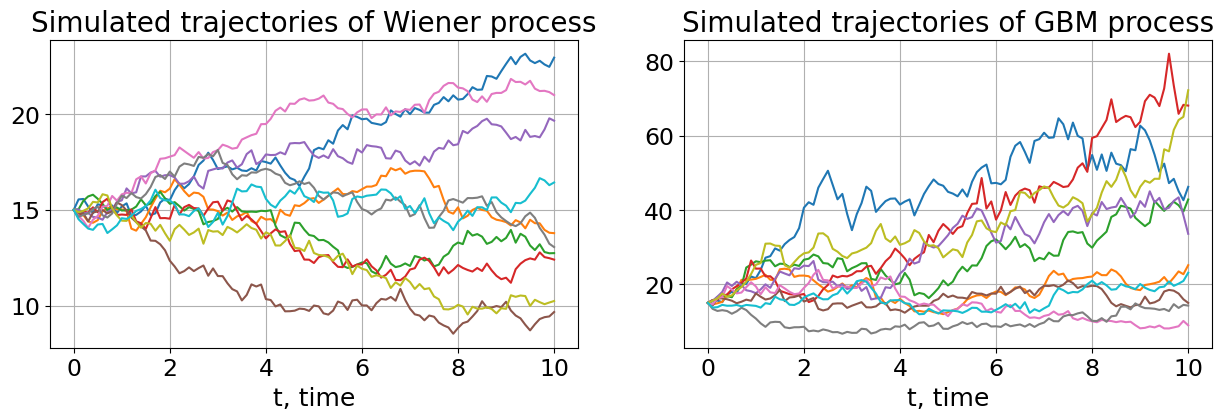

In [4]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

ax1.grid()
ax1.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax1.set_xlabel('t, time',fontsize=18)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.plot(ts,wienTrajs.T)

ax2.grid()
ax2.set_title('Simulated trajectories of GBM process',fontsize=20)
ax2.set_xlabel('t, time',fontsize=18)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax2.plot(ts,gbmTrajs.T)
plt.show()

### Подгонка параметров GBM под данные

Загрузите датасет gbmData.pkl, который идёт вместе с ноутбуком и попробуйте оценить модель геометрического Броуновского движения для него. Нарисуйте график, на котором указаны точки данных, матожидание полученного процесса и доверительный интервал; пунктиром нарисуйте несколько реализаций процесса геометрического Броуновского движения.

In [11]:
with open('/Users/ilushka/Desktop/gbmData.pkl', 'rb') as f:
    data = pickle.load(f)

gb = GBMModel()
gb.fit(data['prices'], data['ts'])

In [12]:
print(f'mu: {gb.mu}')
print(f'sigma: {gb.sigma}')

mu: [0.02378406]
sigma: [0.05130519]


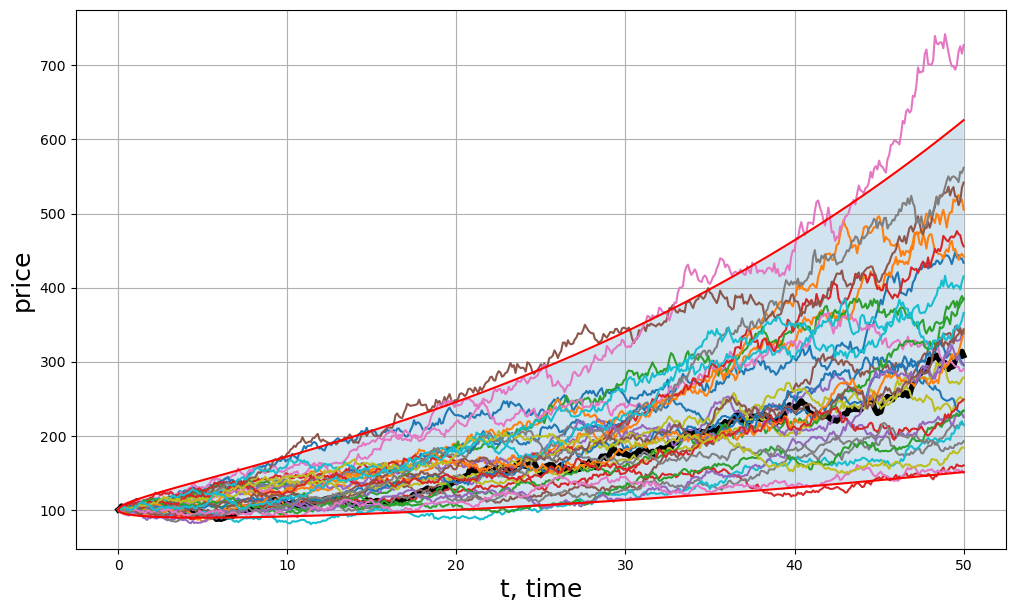

In [13]:
f,ax = plt.subplots(figsize=(12,7))

ax.grid()
ax.plot(data['ts'], data['prices'], linewidth=4, color='black')
ax.set_xlabel('t, time',fontsize=18)
ax.set_ylabel('price',fontsize=18)

ts, xs = data['ts'], data['prices']
Ntraj = 30
x0 = data['prices'][0]

gbmTrajs, confHigh, confLow = gb.simulate(x0, ts, Ntraj, confLevel=0.05)

ax.plot(ts, np.squeeze(gbmTrajs).T)
ax.fill_between(ts, np.squeeze(confHigh), np.squeeze(confLow), alpha=0.2);
ax.plot(ts, confLow, color='red')
ax.plot(ts, confHigh, color='red')

### Проверка качества предсказаний

Проверим, как хорошо делаются предсказания в полученной модели. Для этого обучите модель на первых $60\%$ ряда, а оставшиеся оставьте для тестов. Попробуйте в разных местах обучающей и тестовой части ряда предсказать следующие 50 наблюдений на основе текущего.

Наилучший в смысле среднеквадратической ошибки прогноз -- это условное матожидание

$$
\mathbb{E}[X_{t+h} \vert X_t] = X_t \mathbb{E}[ e^{(\mu - \sigma^2/2)h + \sigma W_h} ].
$$


Процесс Марковский(как увидим позднее), поэтому предыдущая история не важна. Сравните предсказания GBMModel и тестовые значения, нарисуйте доверительные интервалы (можно их построить для прогноза логарифма, а потом взять экспоненту). Насколько модель подходит для короткосрочного и долгосрочного прогноза?

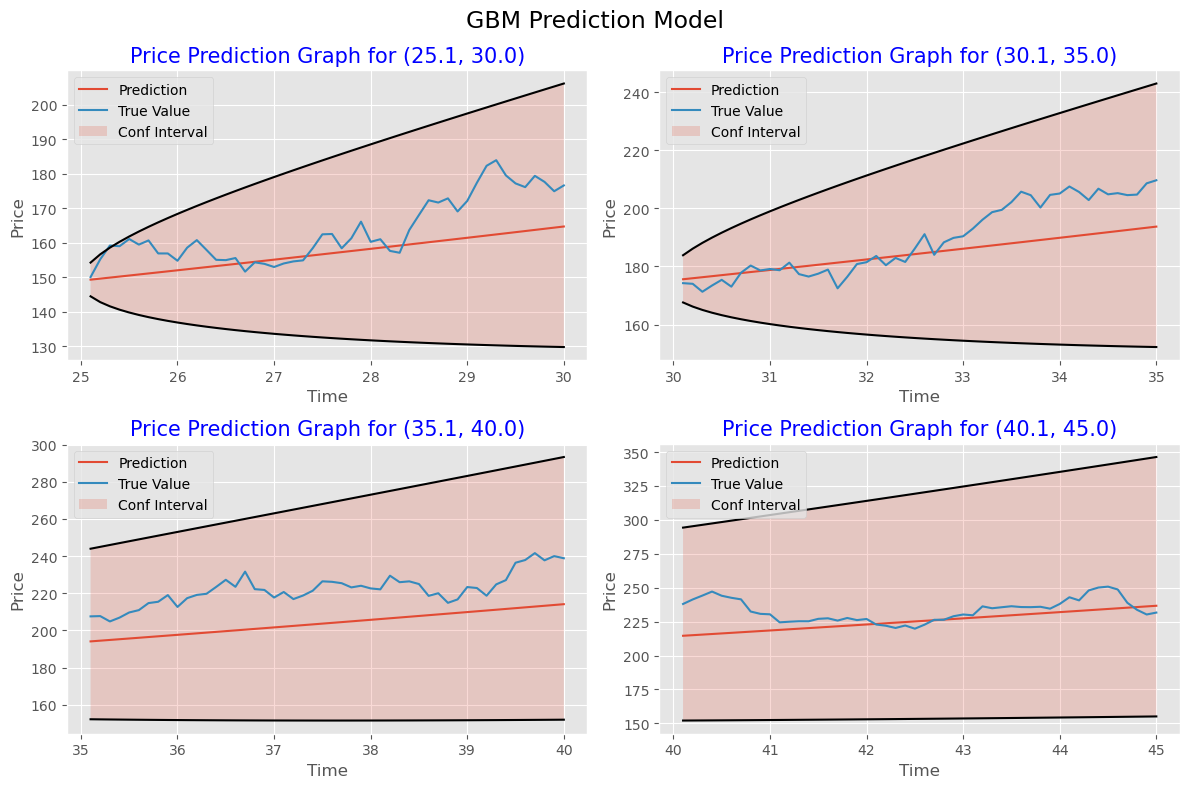

In [14]:
style.use('ggplot') 

train_size = int(0.6 * len(data['ts']))
ts_train, ts_test = data['ts'][:train_size], data['ts'][train_size:]
p_train, p_test = data['prices'][:train_size], data['prices'][train_size:]

gb = GBMModel()
gb.fit(p_train, ts_train)

prediction_periods = [(250, 301), (300, 351), (350, 401), (400, 451)]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('GBM Prediction Model', fontsize=17)

for idx, (start, end) in enumerate(prediction_periods):
    ts_period = list(ts[start:end])
    prices_period = list(xs[start:end])
    
    p_test, preds, confHigh, confLow = gb.predict(ts_period, prices_period, confLevel=0.05)
    
    ax = axs[idx // 2, idx % 2]
    ax.plot(ts_period[1:], preds, label='Prediction')
    ax.plot(ts_period[1:], p_test, label='True Value')
    ax.fill_between(ts_period[1:], confHigh, confLow, alpha=0.2, label='Conf Interval')
    ax.plot(ts_period[1:], confHigh, color='black')
    ax.plot(ts_period[1:], confLow, color='black')
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.set_title(f'Price Prediction Graph for {ts_period[1], ts_period[-1]}', color='blue', fontsize=15)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Видно, что когда мы прогнозируем будущие значения в пределах начала наблюдений, на которых происходило обучение, интервал оказывается сравнительно узким. Это происходит потому, что мы имеем точное знание о последнем известном значении процесса, что позволяет нам достаточно точно подобрать параметры модели. Однако, когда предсказание выходит за рамки непосредственно известных значений и пытается охватить далекое будущее, интервал становится значительно шире из-за увеличения неопределенности и возможности различных траекторий процесса, хотя модель все еще демонстрирует хорошие результаты в аппроксимации данных.


## Часть 2: Задача оценки американского опциона (30 баллов)

### Постановка задачи

Американский опцион даёт право на продажу(put) или покупку(call) актива (или корзины из нескольких активов) по цене страйка $K$ в любой момент времени от $0$ (сейчас) до времени истечения $T$. В классической модели Блека-Шоулза есть безрисковый банковский счёт ставке $r\%$ годовых, а для моделирования цен акций с дивидендами $\delta\%$ годовых используется геометрическое Броуновское движение с параметрами сноса $\mu=r-\delta$ и волатильности $\sigma$. Для простоты в этой задаче мы положим что волатильности $\sigma_i$, дивиденды $\delta_i$ и начальные цены $x_0^i$ у акций отличаются, но цены моделируются как

$$
X^i_t = x_0^i e^{(r-\delta_i - \sigma_i^2/2)t + \sigma_i W^i_t},
$$

где Винеровские процессы $(W^i_t)_{t \in \mathbb{R}_+}$ некоррелированы, то есть, $(W_t)_{t \in \mathbb{R}_+}$ - это $d$-мерный Винеровский процесс.

Из лекций мы знаем, как определяется честная цена европейского опциона, в случае американского идея та же: честная цена равна выгоде, которую можно получить от наилучшего использования опциона. Так как американский опцион можно исполнить в любой момент, то честная цена вычисляется из решения задачи оптимальной остановки:

$$
\max_{\tau \in \Tau} \mathbb{E}\left[ e^{-r\tau}f(X_\tau)\right],
$$

где $f$ -- это функция выплаты опциона, к примеру, $f(x)=(\sum_{i=1}^d x^i - K)_+$, $\tau$ -- это момент остановки, а $\Tau$ -- множество всех возможных времён остановки. Время остановки в данном случае себе проще представлять как решающее правило, которое говорит, когда опцион нужно исполнить, а когда -- подождать ещё. 

Ваша задача состоит в том, чтобы реализовать приближённый метод для оценки американского опциона.


### Описание метода


Для приближённой оценки опциона численными методами, задачу дискретизируют, рассматривая так называемый бермудский опцион, который можно исполнять в моменты $t_k=k\Delta$, где $\Delta=T/p, k=0,..,p$. Для решения этой задачи уже можно пользоваться принципом Беллмана (динамическим программированием). Определим функцию ценности $V_p(x)=f(x)$; действительно, если мы находимся в момент истечения, то опцион сгорает, если мы его не исполнили и приносит прибыль иначе. Более ранние функции ценности строятся рекурсивно: функция ценности 

$$
V_{t_k}(x) = f(x) \vee \left\lbrace e^{-r(t_{k+1}-t_k)} \mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right] \right\rbrace,
$$

где значок $\vee$ обозначает максимум из значения слева и справа. Функция $V_0(x)$ будет, таким образом, честной ценой бермудского опциона при условии текущих цен $X_0=x$.

#### Смещённая вверх оценка (High-Biased Estimator)

Один из подходов может состоять в следующем (Longstaff,Shwarz 2001): на каждом шаге мы решаем задачу регрессии, пытаясь предсказывать

$$
\mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right]
$$
по $X_{t_k}$. Чтобы это реализовать мы из момента $t_0$ семплируем независимо $N$ траекторий из модели $(X_t)$, обозначим траекторию $i$ индексом наверху $X_t^i$. В конце мы задаём вектор

$$
    v_p = (V_p(X_p^i)) = (f(X_p^i)), ~~~ i=1,..,N.
$$

Далее на следующих шагах $k-1<p$ мы обучаем некоторую предсказательную модель $\hat{V}_{k-1}: \mathbb{R}^d \to \mathbb{R}$, которая может предсказать по $X_{t_{k-1}}$ значение $V(X_{t_{k}})$ и задаём вектор

$$
    v_{k-1} = (\hat{V}_{k-1}(X_{t_{k-1}}^i)), ~~~ i=1,..,N.
$$

В самом конце в силу того, что все траектории исходят из одной точки (хотя это легко обобщить)

$$
    \hat{V}_{t_0} = \frac{1}{N} \sum_{i=1}^N \hat{V}_{1}(X_{t_1}^i).
$$

#### Нижняя оценка (Lower Bound)

Оказывается, мы можем дёшево получить нижнюю оценку, просто просимулировав ещё $N_{test}$ новых траекторий и посчитав результат обученных моделей (без дополнительного обучения) точно так же как, выше. Можно себе это представлять как разбиение на train и test в классическом машинном обучении.

Оказывается, что в отличие от классических приложений ML, в этой задаче можно даже построить верхнюю оценку. Чуть позже в курсе мы обсудим, как её можно получить, это уже является более сложным вопросом.

### Имплементация метода

Для реализации нам понадобится модуль симуляции многомерного геометрического Броуновского движения, модуль, реализующий функцию ценности, и модуль, который служит непосредственно для оценки заданного опциона.

Можете использовать для начала шаблоны кода ниже.

#### Симуляция GBM

Уже был реализован в предыдущей части.

#### (Приближённая) Функция ценности

Функция ценности имеет метод для оценки условного матожидания и метод для обучения и предсказания. Практически полностью повторяет sklearn, но с дополнительной обёрткой иногда удобнее.

In [15]:
class ValueFunction:
    def __init__(self, model=None):
        if model is None:
            self.model = LinearRegression()
        else:
            self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

    def get_parameters(self):
        try:
            return {'coefficients': self.model.coef_, 'intercept': self.model.intercept_}
        except AttributeError:
            return "Model does not support retrieval of parameters."



In [16]:
vf = ValueFunction()

xTests = np.concatenate([ np.ones([5,1]),(np.arange(0,1,1/5)[:,None]), (np.arange(0,1,1/5)[:,None])**2],axis=-1)
yTests = 0.2*(np.arange(0,1,1/5)[:,None])**3 + 0.8* (np.arange(0,1,1/5)[:,None])**2 - 2*(np.arange(0,1,1/5)[:,None]) + 3

vf.fit(xTests,yTests)

print(vf.get_parameters())
#compare to the true parameters!


{'coefficients': array([[ 0.    , -2.0688,  1.04  ]]), 'intercept': array([3.00192])}


В этом примере видно, что константный член в регрессионном уравнении с высокой точностью соответствует значению 3 ($3.00192 \approx 3$), а коэффициент перед линейным членом практически равен -2 ($-2.0688 \approx -2$). Однако, в настоящей модели присутствует влияние кубического члена, которое в нашем анализе не учтено из-за его отсутствия в данных для обучения. 

#### Метод оценки опциона

Теперь реализуем сам метод оценки. Мы должны уметь вычислить как смещённую оценку, так и нижнюю. Используйте шаблон ниже.

In [17]:
class OptionPricer:
    def __init__(self, priceModel, payment, executionTimes, discountFunction):
        self.priceModel = priceModel
        self.payment = payment
        self.executionTimes = executionTimes
        self.continuationModels = [ValueFunction() for _ in range(len(executionTimes)-1)]
        self.discountFunction = discountFunction

    def computeHighBiasEstimator(self, r, x0, N):
        t = np.array(self.executionTimes)
        xs = self.priceModel.simulate_option(x0, t, N)
        dec = self.payment(xs[:, :, -1])
        
        for i in range(len(t) - 2, -1, -1):
            X = xs[:, :, i]
            self.continuationModels[i].fit(X, dec)
            if i == 0:
                df = self.discountFunction(r, t[i + 1] - t[i])
                finals = dec
                highE = np.mean(finals) 
                highS = np.std(finals) / np.sqrt(N)
            else:
                contVal = self.continuationModels[i].predict(X) * self.discountFunction(r, t[i + 1] - t[i])
            exVal = self.payment(X)
            dec = np.where(exVal > contVal, exVal, contVal)

        return highE, highS

    def computeLowEstimator(self, r, x0, N):
        t = np.array(self.executionTimes)
        xs = self.priceModel.simulate_option(x0, t, N)
        eep = np.full(N, -np.inf)
        for i, ti in enumerate(t):
            X = xs[:, :, i]
            if i == len(t) - 1:
                finExVals = self.payment(X)
                eep[eep == -np.inf] = finExVals[eep == -np.inf] * self.discountFunction(r, ti)
            else:
                contVal = self.continuationModels[i].predict(X) * self.discountFunction(r, t[i + 1] - ti)
                exVal = self.payment(X)
                upd = exVal > contVal
                eep[upd] = exVal[upd] * self.discountFunction(r, ti)
        lowE = np.mean(eep[eep != -np.inf])
        lowS = np.std(eep[eep != -np.inf]) / np.sqrt(N)

        return lowE, lowS


### Проведение экспериментов

Прим.: $+$ это то же, что [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

В качестве иллюстрации метода, рассмотрим три пример с функцией выплаты $f(x) = (\max_i x_i - K)_+$ (американский max-call опцион со страйком $K=100$) для двух акций $X^1,X^2$ с начальными ценами

1. $X_0= [100,100]$;
2. $X_0= [110,110]$;
3. $X_0= [90,90]$.

Параметры модели: банковская процентная ставка $r=0.05$ годовых, для каждой акции дивиденды $\delta=0.1$ годовых, волатильность $\sigma=0.2$, истечение срока опциона $T=1$ год. Используется геометрическое Броуновское движение с параметрами $\mu=r-\delta$ и $\sigma$, шаг дискретизации $0.1$ (число разбиений равно $10$). Max-call опцион позволяет купить товар из корзины, который имеет максимальную цену в момент исполнения, по цене страйка $K$.

Для каждого из трёх сценариев проведите следующий эксперимент: посчитайте цену опциона(high-biased) для числа траекторий для обучения $N=500,1000,2000,4000,8000,16000$ и вычислите для каждого из них нижнюю оценку на $N_{test}=40000$ траекториях. Постройте график с двумя кривыми цен и гауссовскими доверительными интервалами, отображающий зависимость вычисленной цены от $N$. Сделайте вывод: какой из трёх опционов дороже? Как вы считаете, почему?

Сравните вычисленные цены с ценой европейского опциона для этих трёх примеров, в чём причина того, что его цена ниже?

In [18]:
def computePayment(xs, K=100):
    return np.maximum(np.max(xs, axis=1) - K, 0)

def computeDiscount(r, t):
    return np.exp(-r * t)

In [19]:
r = 0.05
delta = 0.1
sigma = 0.2
mu = r - delta
T = 1
dt = 0.1
executionTimes = np.arange(0, T + dt, dt)

gbmModel = GBMModel(mu=mu, sigma=sigma)
optionPricer = OptionPricer(priceModel=gbmModel, payment=computePayment, executionTimes=executionTimes, discountFunction=computeDiscount)

Ntrajs = 16000
Ntrajs_t = 40000
x0 = np.array([100, 100])

print(optionPricer.computeHighBiasEstimator(r, x0, Ntrajs))

(16.09523464314686, 0.031238206108178818)


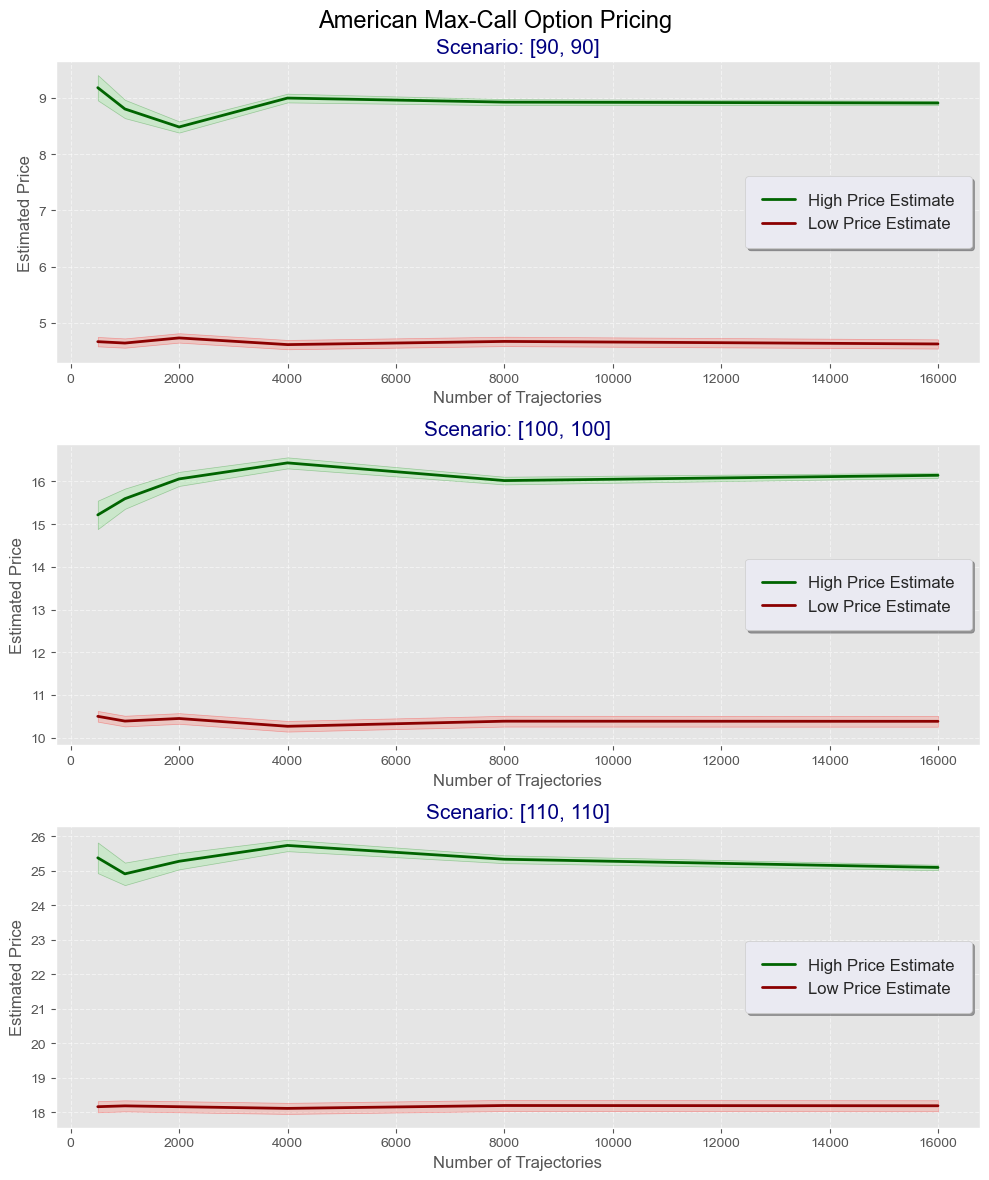

In [20]:
np.random.seed(322)
Ntrajs_high = [500, 1000, 2000, 4000, 8000, 16000]
Ntrajs_low = 40000
x0_scenarios = [[90, 90], [100, 100], [110, 110]]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
fig.suptitle('American Max-Call Option Pricing', fontsize=17)
plt.style.use('seaborn-darkgrid')
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['legend.fontsize'] = 12

for idx, scen in enumerate(x0_scenarios):
    highEsts, lowEsts = [], []
    highSds, lowSds = [], []
    for N in Ntrajs_high:
        highE, highSd = optionPricer.computeHighBiasEstimator(r, np.array(scen), N)
        lowE, lowSd = optionPricer.computeLowEstimator(r, np.array(scen), Ntrajs_low)
        highEsts.append(highE)
        lowEsts.append(lowE)
        highSds.append(highSd)
        lowSds.append(lowSd)

    confHH, confHL = np.array(highEsts) + 1.96 * np.array(highSds), np.array(highEsts) - 1.96 * np.array(highSds)
    confLH, confLL = np.array(lowEsts) + 1.96 * np.array(lowSds), np.array(lowEsts) - 1.96 * np.array(lowSds)
    
    axs[idx].plot(Ntrajs_high, highEsts, color='darkgreen', linestyle='-', linewidth=2, label='High Price Estimate')
    axs[idx].plot(Ntrajs_high, lowEsts, color='darkred', linestyle='-', linewidth=2, label='Low Price Estimate')
    axs[idx].fill_between(Ntrajs_high, confHH, confHL, color='lightgreen', alpha=0.3, edgecolor='green', linewidth=0.5)
    axs[idx].fill_between(Ntrajs_high, confLH, confLL, color='salmon', alpha=0.3, edgecolor='red', linewidth=0.5)
    axs[idx].set_xlabel('Number of Trajectories')
    axs[idx].set_ylabel('Estimated Price')
    axs[idx].set_title(f'Scenario: {scen}', color='navy')
    axs[idx].grid(True, linestyle='--', alpha=0.5)
    axs[idx].legend(frameon=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.show()


In [21]:
np.random.seed(322)

def calcEuroPx(mdl, x0, times, N):
    t = np.array(times)
    px = mdl.simulate_option(x0, t, N)
    
    return computeDiscount(r, T) * np.mean(computePayment(px[:, :, -1]))

for x in x0_scenarios:
    print(f'Eu Max-Call Px (X0: {x}): {calcEuroPx(gbmModel, np.array(x), executionTimes, 40000)}')


Eu Max-Call Px (X0: [90, 90]): 4.134300737077438
Eu Max-Call Px (X0: [100, 100]): 9.586962118836091
Eu Max-Call Px (X0: [110, 110]): 17.293378657013044


1) Наблюдаемая тенденция ценообразования показывает, что опцион с начальными стоимостями базовых активов в [90, 90] оказался наиболее доступным, в то время как опцион, начальная стоимость которого составляла [110, 110], стал наиболее высоко оцененным. Это согласуется с ожиданиями, поскольку равномерное распределение приростов стоимости активов подразумевает, что первоначальная цена имеет решающее значение в определении стоимости опциона.

2) Цены на Американские Max-Call опционы превысили стоимость их Европейских аналогов. Это различие возникает из-за гибкости Американских опционов, которые могут быть исполнены в любой выбранный момент до истечения срока действия. Такая возможность предоставляет владельцу Американского опциона дополнительные стратегические варианты по сравнению с Европейским опционом, делая Американский опцион по определению более ценным, чем Европейский.